# Challenge : predict conversions üèÜüèÜ

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you üß®üß®  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [1]:
!pip install plotly

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix,roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "iframe" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

# Read file with labels

In [3]:
dataset = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', dataset.shape)

Set with labels (our train+test) : (284580, 6)


In [4]:
dataset.head()

country  age  new_user  source  total_pages_visited  converted
0    China   22         1  Direct                    2          0
1       UK   21         1     Ads                    3          0
2  Germany   20         0     Seo                   14          1
3       US   23         1     Seo                    3          0
4       US   28         1  Direct                    3          0

In [5]:
desc = dataset.describe(include='all')
display(desc)
print(dataset.shape)

country            age       new_user  source  total_pages_visited  \
count   284580  284580.000000  284580.000000  284580        284580.000000   
unique       4            NaN            NaN       3                  NaN   
top         US            NaN            NaN     Seo                  NaN   
freq    160124            NaN            NaN  139477                  NaN   
mean       NaN      30.564203       0.685452     NaN             4.873252   
std        NaN       8.266789       0.464336     NaN             3.341995   
min        NaN      17.000000       0.000000     NaN             1.000000   
25%        NaN      24.000000       0.000000     NaN             2.000000   
50%        NaN      30.000000       1.000000     NaN             4.000000   
75%        NaN      36.000000       1.000000     NaN             7.000000   
max        NaN     123.000000       1.000000     NaN            29.000000   

            converted  
count   284580.000000  
unique            NaN  
top               NaN  
freq              NaN  
mean         0.032258  
std          0.176685  
min          0.000000  
25%          0.000000  
50%          0.000000  
75%          0.000000  
max          1.000000

(284580, 6)


In [6]:
display(100*dataset.isnull().sum()/dataset.shape[0]) #no missing values

country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

In [7]:
#Removing outlier from age
dataset = dataset.loc[dataset['age'] < 70,:]

dataset['new_user'].replace({1 : 'Yes', 0 : 'No'}, inplace = True)

# Explore dataset

In [8]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
#data_sample = data.sample(10000)

In [9]:
data=dataset.sample(1000)

Text(0, 0.5, 'Convertion, %')

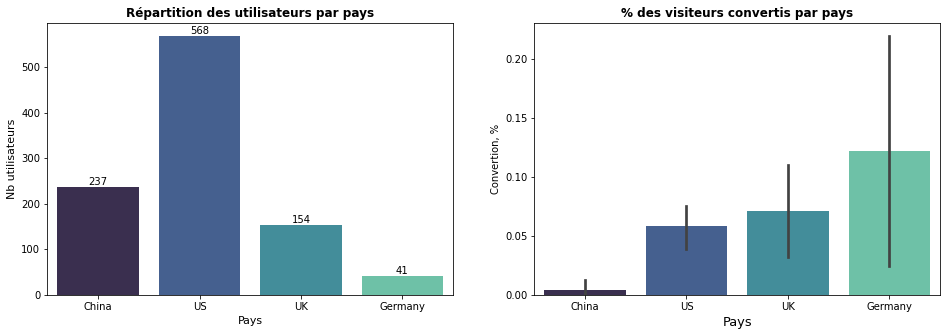

In [10]:
#R√©partition des utilisateurs par pays
plt.figure(figsize=(16,5))
plt.subplot(121) 
ax1 = sns.countplot(x='country', data=data, palette='mako')
ax1.set_title('R√©partition des utilisateurs par pays', fontsize = 12,fontweight='bold' )
ax1.set_xlabel('Pays', fontsize = 11)
ax1.set_ylabel('Nb utilisateurs', fontsize = 11)
for rect in ax1.patches:
    ax1.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 5,rect.get_height(),horizontalalignment='center', fontsize = 10)
    
plt.subplot(122)
ax2 = sns.barplot(x='country', y='converted', data=data, palette='mako')
ax2.set_title('% des visiteurs convertis par pays', fontsize = 12,fontweight='bold')
ax2.set_xlabel('Pays', fontsize = 13)
ax2.set_ylabel('Convertion, %')

Text(0, 0.5, 'Convertion, %')

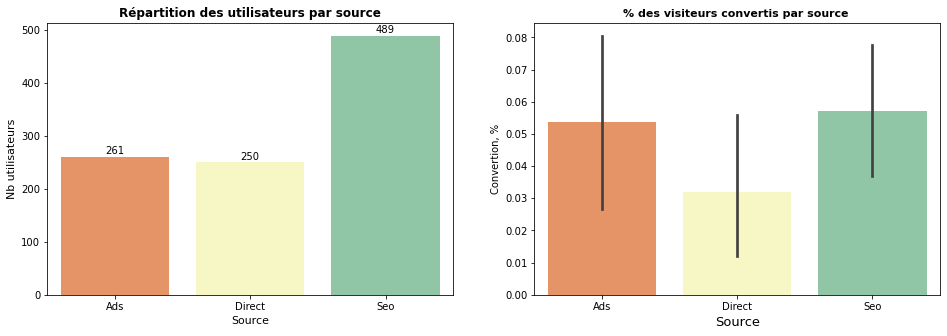

In [11]:
#R√©partition des utilisateurs par source
plt.figure(figsize=(16,5))
plt.subplot(121) 
ax1 = sns.countplot(x='source', data=data, palette='Spectral')
ax1.set_title('R√©partition des utilisateurs par source',fontsize = 12, fontweight='bold' )
ax1.set_xlabel('Source', fontsize = 11)
ax1.set_ylabel('Nb utilisateurs', fontsize = 11)
for rect in ax1.patches:
    ax1.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 5,rect.get_height(),horizontalalignment='center', fontsize = 10)
    
plt.subplot(122)
ax2 = sns.barplot(x="source", y='converted', data=data,  palette='Spectral')
ax2.set_title('% des visiteurs convertis par source ',fontsize = 11, fontweight='bold')
ax2.set_xlabel('Source', fontsize = 13)
ax2.set_ylabel('Convertion, %')
 

Visualisation des variables

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



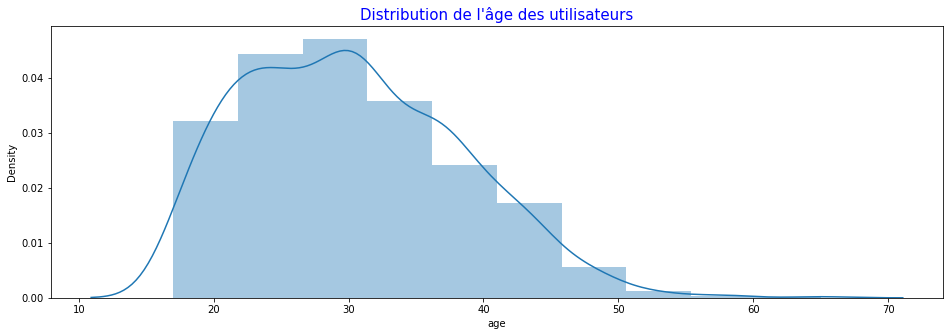

In [12]:
fig, ax = plt.subplots(figsize=(16,5))
sns.distplot(data.age, ax=ax,norm_hist=True, bins=10)
plt.title("Distribution de l'√¢ge des utilisateurs", fontsize=15, color='b')
plt.show()

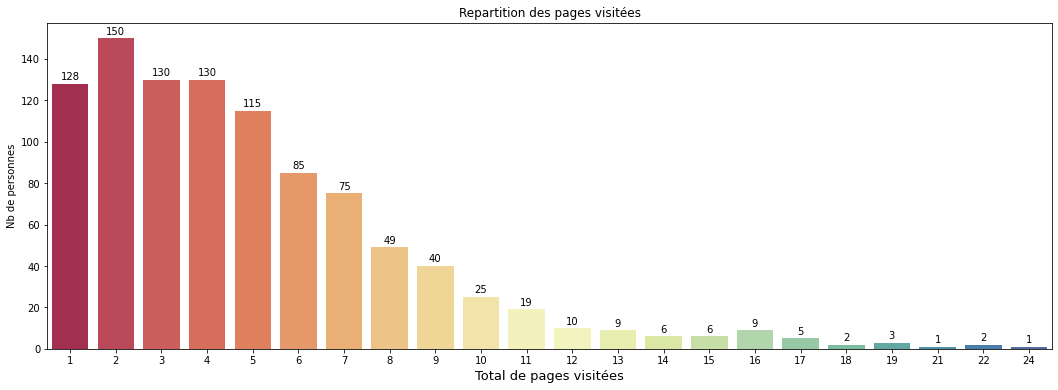

In [13]:
plt.figure(figsize=(18,6))
ax = sns.countplot(x = data["total_pages_visited"], palette='Spectral');
ax.set_ylabel("Nb de personnes")
ax.set_title("Repartition des pages visit√©es")
ax.set_xlabel("Total de pages visit√©es", fontsize=13)
ax.set_xticklabels(ax.get_xticklabels(), 
                    fontsize=10, 
                    rotation=0)
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 2,rect.get_height(),horizontalalignment='center', fontsize = 10)
plt.show();

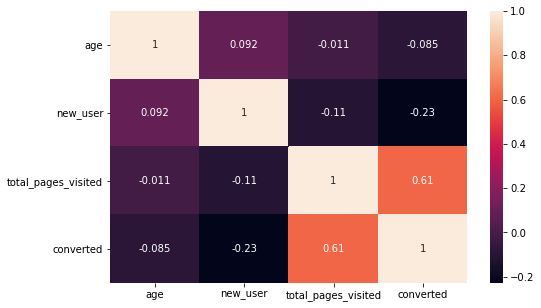

In [14]:
# Correlation matrix
plt.figure(figsize= (8,5))
sns.heatmap(data.corr(), annot= True,);

# Make your model

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

In [15]:
# Preprocessing

In [16]:
features_list = ['country','age','new_user','source','total_pages_visited']
numeric_indices = [1,4]
categorical_indices = [0,2,3]
target_variable = 'converted'

In [17]:
# Separate target variable Y from features X
X = data.loc[:, features_list]
Y = data[target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited'], dtype='object')



In [18]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [19]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.to_list()
Y_test = Y_test.to_list()
print("...Done")

print(X_train[0:5,:])
print(X_test[0:2,:])
print()
print(Y_train[0:5])
print(Y_test[0:2])

Convert pandas DataFrames to numpy arrays...
...Done
[['China' 44 1 'Seo' 5]
 ['China' 34 1 'Seo' 7]
 ['China' 37 0 'Ads' 2]
 ['UK' 21 1 'Seo' 3]
 ['US' 25 0 'Seo' 2]]
[['US' 25 0 'Seo' 10]
 ['China' 34 0 'Seo' 5]]

[0, 0, 0, 0, 0]
[0, 0]


## Training pipeline

In [20]:
# Encoding categorical features and standardizing numerical features
print("Encoding categorical features and standardizing numerical features...")
print()
print(X_train[0:5,:])

# Normalization
numeric_transformer = StandardScaler()

# OHE / dummyfication
categorical_transformer = OneHotEncoder(drop='first')

featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_indices),    
        ('num', numeric_transformer, numeric_indices)
        ]
    )

X_train = featureencoder.fit_transform(X_train)
print("...Done")
print(X_train[0:5,:])

Encoding categorical features and standardizing numerical features...

[['China' 44 1 'Seo' 5]
 ['China' 34 1 'Seo' 7]
 ['China' 37 0 'Ads' 2]
 ['UK' 21 1 'Seo' 3]
 ['US' 25 0 'Seo' 2]]
...Done
[[ 0.          0.          0.          1.          0.          1.
   1.71409084  0.03166783]
 [ 0.          0.          0.          1.          0.          1.
   0.45972506  0.60097709]
 [ 0.          0.          0.          0.          0.          0.
   0.83603479 -0.82229606]
 [ 0.          1.          0.          1.          0.          1.
  -1.17095046 -0.53764143]
 [ 0.          0.          1.          0.          0.          1.
  -0.66920415 -0.82229606]]


In [21]:
# Train model
print("Train model...")
regressor = LogisticRegression()
regressor.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [22]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = regressor.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [23]:
## Test pipeline

In [24]:
# Encoding categorical features and standardizing numerical features
print("Encoding categorical features and standardizing numerical features...")
print()
X_test = featureencoder.transform(X_test)
print("...Done")
print(X_test[0:5,:])

Encoding categorical features and standardizing numerical features...

...Done
[[ 0.          0.          1.          0.          0.          1.
  -0.66920415  1.45494098]
 [ 0.          0.          0.          0.          0.          1.
   0.45972506  0.03166783]
 [ 0.          0.          1.          0.          0.          1.
   0.83603479  4.01683266]
 [ 0.          0.          0.          1.          1.          0.
  -0.79464072 -1.10695069]
 [ 0.          1.          0.          1.          0.          1.
   0.2088519   1.73959561]]


In [25]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = regressor.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]



In [26]:
#Model's Performance assessment on training dataset¬∂

In [27]:
# Print f1 scores
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.78125
f1-score on test set :  0.8


In [28]:
# Perform 3-fold cross-validation to evaluate the generalized R2 score
print("K-fold cross-validation...")
regressor = LogisticRegression()
scores = cross_val_score(regressor, X_train, Y_train, cv=3)
print('The cross-validated R2-score is : ', scores.mean())
print('The standard deviation is : ', scores.std())

K-fold cross-validation...
The cross-validated R2-score is :  0.9812358611885519
The standard deviation is :  0.009220142670813374


In [29]:
# Perform grid search
print("Grid search...")

# Grid of values to be tested
params = {
    'C': np.arange(1,3,0.1)
}
gridsearch = GridSearchCV(regressor, param_grid = params, cv = 3,scoring="f1")
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch.predict(X_train)
print(sklearn.metrics.classification_report(Y_train, gridsearch.predict(X_train)))

Grid search...
...Done.
Best hyperparameters :  {'C': 1.0}
Predictions on training set...
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       764
           1       0.89      0.69      0.78        36

    accuracy                           0.98       800
   macro avg       0.94      0.85      0.89       800
weighted avg       0.98      0.98      0.98       800

